# Качество вин и композиция алгоритмов

Скачаем набор данных из репозитория UCI.

In [1]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv(url, sep=";")

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Целевая переменная:

In [6]:
data.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

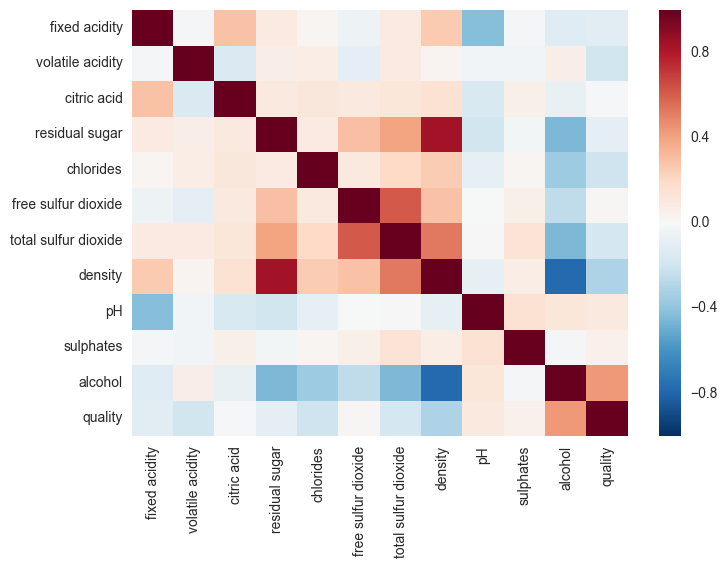

In [8]:
sns.heatmap(data.corr())
plt.show()

In [9]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
X = data.drop('quality', axis=1)
y = data.quality

Возьмем для бейзлайна два простых алгоритма и dummy-правило - решающее дерево и линейный метод опорных векторов, оценим качество их работы и будем отталкиваться от него:

In [11]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import LinearSVR

In [12]:
regr = DecisionTreeRegressor(max_depth=15)
print("Decision tree regressor: {}".format(cross_val_score(regr, X,y, scoring="neg_mean_squared_error").mean()))
lin_regr = LinearSVR(C=0.001)
print("Linear support vector regressor: {}".format(cross_val_score(lin_regr,X,y, scoring="neg_mean_squared_error").mean()))
dummy = DummyRegressor(strategy="mean")
print("Dummy regressor: {}".format(cross_val_score(dummy,X,y, scoring="neg_mean_squared_error").mean()))

Decision tree regressor: -1.0340331443937716
Linear support vector regressor: -0.6541706403862252
Dummy regressor: -0.7868556799489482


#### Отрицательные значения ошибки?
Как из такой формулы получили отрицательное значение?

$$ \large MSE = \frac{1}{n}\sum^{n}_{i=1} (y_i - \hat{y}_i)^2$$

<img src="chan.jpg"/>

В sklearn есть немного контр-интуитивная штука - в метриках используется идея "больше-лучше", поэтому к среднеквадратичной ошибке приписывают минус.

Отдельно видим, что разница между тупым регрессором и линейным не так уж и велика, а решающее дерево вообще оказалось тупее "среднего".

### Разложение ошибки на смещение и разброс (Bias-variance decomposition)

Поговорим немного о свойствах оценки(которую можно вывести, например, из линейной регрессии). Мы предполагаем, что:
- истинное значение целевой переменной складывается из некоторой детерминированной функции $f\left(\vec{x}\right)$ и случайной ошибки $\epsilon$: $y = f\left(\vec{x}\right) + \epsilon$;
- ошибка распределена нормально с центром в нуле и некоторым разбросом: $\epsilon \sim \mathcal{N}\left(0, \sigma^2\right)$;
- истинное значение целевой переменной тоже распределено нормально: $y \sim \mathcal{N}\left(f\left(\vec{x}\right), \sigma^2\right)$
- мы пытаемся приблизить детерминированную, но неизвестную функцию $f\left(\vec{x}\right)$ линейной функцией от регрессоров $\hat{f}\left(\vec{x}\right)$, которая, в свою очередь, является точечной оценкой функции $f$ в пространстве функций (точнее, мы ограничили пространство функций параметрическим семейством линейных функций), т.е. случайной переменной, у которой есть среднее значение и дисперсия.

Тогда ошибка в точке $\vec{x}$ раскладывается следующим образом:

$$\large \begin{array}{rcl} 
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \mathbb{E}\left[y^2\right] + \mathbb{E}\left[\left(\hat{f}\left(\vec{x}\right)\right)^2\right] - 2\mathbb{E}\left[y\hat{f}\left(\vec{x}\right)\right] \\
&=& \mathbb{E}\left[y^2\right] + \mathbb{E}\left[\hat{f}^2\right] - 2\mathbb{E}\left[y\hat{f}\right] \\
\end{array}$$

Для наглядности опустим обозначение аргумента функций. Рассмотрим каждый член в отдельности, первые два расписываются легко по формуле $\text{Var}\left(z\right) = \mathbb{E}\left[z^2\right] - \mathbb{E}\left[z\right]^2$:

$$\large \begin{array}{rcl} 
\mathbb{E}\left[y^2\right] &=& \text{Var}\left(y\right) + \mathbb{E}\left[y\right]^2 = \sigma^2 + f^2\\
\mathbb{E}\left[\hat{f}^2\right] &=& \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 \\
\end{array}$$

Пояснения:

$$\large \begin{array}{rcl} 
\text{Var}\left(y\right) &=& \mathbb{E}\left[\left(y - \mathbb{E}\left[y\right]\right)^2\right] \\
&=& \mathbb{E}\left[\left(y - f\right)^2\right] \\
&=& \mathbb{E}\left[\left(f + \epsilon - f\right)^2\right] \\
&=& \mathbb{E}\left[\epsilon^2\right] = \sigma^2
\end{array}$$

$$\large \mathbb{E}[y] = \mathbb{E}[f + \epsilon] = \mathbb{E}[f] + \mathbb{E}[\epsilon] = f$$

И теперь последний член суммы. Мы помним, что ошибка и целевая переменная независимы друг от друга:

$$\large \begin{array}{rcl} 
\mathbb{E}\left[y\hat{f}\right] &=& \mathbb{E}\left[\left(f + \epsilon\right)\hat{f}\right] \\
&=& \mathbb{E}\left[f\hat{f}\right] + \mathbb{E}\left[\epsilon\hat{f}\right] \\
&=& f\mathbb{E}\left[\hat{f}\right] + \mathbb{E}\left[\epsilon\right] \mathbb{E}\left[\hat{f}\right]  = f\mathbb{E}\left[\hat{f}\right]
\end{array}$$

Наконец, собираем все вместе:

$$\large \begin{array}{rcl} 
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 - 2f\mathbb{E}\left[\hat{f}\right] \\
&=& \left(f - \mathbb{E}\left[\hat{f}\right]\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2 \\
&=& \text{Bias}\left(\hat{f}\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2
\end{array}$$

Итак, мы достигли цели всех вычислений, описанных выше, последняя формула говорит нам, что ошибка прогноза любой модели вида $y = f\left(\vec{x}\right) + \epsilon$ складывается из:

- квадрата смещения: $\text{Bias}\left(\hat{f}\right)$ – средняя ошибка по всевозможным наборам данных;
- дисперсии: $\text{Var}\left(\hat{f}\right)$ – вариативность ошибки, то, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных;
- неустранимой ошибки: $\sigma^2$.

Если с последней мы ничего сделать не можем, то на первые два слагаемых мы можем как-то влиять. В идеале, конечно же, хотелось бы свести на нет оба этих слагаемых (левый верхний квадрат рисунка), но на практике часто приходится балансировать между смещенными и нестабильными оценками (высокая дисперсия).

<img src="bvtf.png" width="480">

Как правило, при увеличении сложности модели (например, при увеличении количества свободных параметров) уменьшается дисперсия (разброс) оценки, но оценка становится смещенной. Из-за того что тренировочный набор данных полностью запоминается вместо обобщения, небольшие изменения приводят к неожиданным результатам (переобучение). Если же модель слабая, то она не состоянии выучить закономерность, в результате выучивается что-то другое, смещенное относительно правильного решения.

<img src="biasvariance.png" width="480">

Теорема Маркова-Гаусса как раз утверждает, что МНК-оценка параметров линейной модели является самой лучшей в классе несмещенных линейных оценок, то есть с наименьшей дисперсией. Это значит, что если существует какая-либо другая несмещенная модель $g$ тоже из класса линейных моделей, то мы можем быть уверены, что $Var\left(\hat{f}\right) \leq Var\left(g\right)$.

# Ансамбли

Что делать, если вы уже нашли лучшую модель и повысить точность модели больше не можете? В таком случае нужно применить более продвинутые техники машинного обучения, которые можно объединить словом «ансамбли». Ансамбль — это некая совокупность, части которой образуют единое целое. Из повседневной жизни вы знаете музыкальные ансамбли, где объединены несколько музыкальных инструментов, архитектурные ансамбли с разными зданиями и т.д. 


Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян. 
Их собралось около 800 человек и они пытались угадать вес быка, который стоял перед ними. Его вес составлял 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.
Эту идею уменьшения ошибки применили и в машинном обучении.

### Бутстрэп

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман [Ле́о Бре́йманом](https://ru.wikipedia.org/wiki/Брейман,_Лео) в 1994 году. Бэггинг основан на статистическом методе бутстрэппинга, который позволяет оценивать многие статистики сложных моделей.

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

![image](bootstrap.png)

### Бэггинг

Теперь мы можем перейти непосредственно к бэггингу. Пусть имеется обучающая выборка $\large X$. С помощью бутстрэпа сгенерируем из неё выборки $\large X_1, \dots, X_M$. Теперь на каждой выборке обучим свой классификатор $\large a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. Эту схему можно представить картинкой ниже.

<img src="bagging.png" alt="image"/>

Рассмотрим задачу регрессии с базовыми алгоритмами $\large b_1(x), \dots , b_n(x)$. Предположим, что существует истинная функция ответа для всех объектов $\large y(x)$, а также задано распределение на объектах $\large p(x)$. В этом случае мы можем записать ошибку каждой функции регрессии $$ \large \varepsilon_i(x) = b_i(x) − y(x),  i = 1, \dots, n$$
и записать матожидание среднеквадратичной ошибки $$ \large E_x(b_i(x) − y(x))^{2} = E_x \varepsilon (x). $$

Средняя ошибка построенных функций регрессии имеет вид $$ \large E_1 = \frac{1}{n}E_x\varepsilon_i^{2}(x) $$

Предположим, что ошибки несмещены и некоррелированы: 

$$ \large \begin{array}{rcl} E_x\varepsilon_i(x) &=& 0, \\
E_x\varepsilon_i(x)\varepsilon_j(x) &=& 0, i \neq j. \end{array}$$

Построим теперь новую функцию регрессии, которая будет усреднять ответы построенных нами функций:
$$ \large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x) $$

Найдем ее среднеквадратичную ошибку:

$$ \large \begin{array}{rcl}E_n &=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\Big)^2 \\
&=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\Big)^2 \\
&=& \frac{1}{n^2}E_x\Big(\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\Big) \\
&=& \frac{1}{n}E_1\end{array}$$

Таким образом, усреднение ответов позволило уменьшить средний квадрат ошибки в n раз!

Напомним вам из предыдущего [урока](https://habrahabr.ru/company/ods/blog/323890/#razlozhenie-oshibki-na-smeschenie-i-razbros-bias-variance-decomposition), как раскладывается общая ошибка:
$$\large \begin{array}{rcl} 
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 - 2f\mathbb{E}\left[\hat{f}\right] \\
&=& \left(f - \mathbb{E}\left[\hat{f}\right]\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2 \\
&=& \text{Bias}\left(\hat{f}\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2
\end{array}$$

Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.


In [13]:
from sklearn.ensemble import BaggingRegressor

In [14]:
bagging_regr = BaggingRegressor(base_estimator=DecisionTreeRegressor())
regr = DecisionTreeRegressor(max_depth=15)
print("Decision tree regressor: {}".format(cross_val_score(regr, X,y, scoring="neg_mean_squared_error").mean()))
print("Bagging tree regressor: {}".format(cross_val_score(bagging_regr, X,y, scoring="neg_mean_squared_error").mean()))

Decision tree regressor: -1.033573770919748
Bagging tree regressor: -0.611176478092768


Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению существенно различных базовых классификаторов. В случае больших выборок обычно генерируют подвыборки существенно меньшей длины.



### Out-of-bag error

Забегая вперед, отметим, что при использовании случайных лесов нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Внутренняя оценка во время работы получается следующим образом:

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используется при построении k-го дерева.

Это можно легко доказать: пусть в выборке $\large \ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью  $\large\frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $\large \ell$ раз): $\large (1 - \frac{1}{\ell})^\ell$. При $\large \ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\large \frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\large \approx  1 - \frac{1}{e} \approx 63\%$.

Давайте рассмотрим, как это работает на практике:

![image](oob.png)
На рисунке видно, что наш классификатор ошибся в 4 наблюдениях, которые мы не использовали для тренировки. Значит точность нашего классификатора: $\large \frac{11}{15}*100\% = 73.33\%$

Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

# Случайный лес
<img src="18.jpg" width=50% />
Случайный лес — один из самых потрясающих алгоритмов машинного обучения, придуманные Лео Брейманом и Адель Катлер ещё в прошлом веке. Он дошёл до нас в «первозданном виде» (никакие эвристики не смогли его существенно улучшить) и является одним из немногих универсальных алгоритмов. Универсальность заключается, во-первых, в том, что он хорош во многих задачах (по моим оценкам, 70% из встречающихся на практике, если не учитывать задачи с изображениями), во-вторых, в том, что есть случайные леса для решения задач классификации, регрессии, кластеризации, поиска аномалий, селекции признаков и т.д.

### Алгоритм

Алгоритм построения случайного леса, состоящего из $\large N$ деревьев, выглядит следующим образом:
* Для каждого $\large n = 1, \dots, N$:
     * Сгенерировать выборку $\large X_n$ с помощью bootstrap.
     * Построить решающее дерево $\large b_n$ по выборке $\large X_n$:
         — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         — дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         — при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
%%time
rf_reg = RandomForestRegressor(n_estimators=100, oob_score=True)
print("Random forest regressor: {}".format(cross_val_score(rf_reg, X,y, scoring="neg_mean_squared_error").mean()))

Random forest regressor: -0.5682205868844782
CPU times: user 5.96 s, sys: 0 ns, total: 5.96 s
Wall time: 5.96 s


# Попробуем решить Титаник

In [17]:
df = pd.read_csv('train.csv') 

In [18]:
def preprocess_data(data):
    df = data.copy()
    df["HadCabin"] = ~df.Cabin.isnull()
    df.HadCabin = df.HadCabin.astype('int')
    df.Sex = df.Sex.replace({'female':0, 'male':1})
    df.drop('Ticket', axis=1, inplace=True)
    df.drop("Embarked", axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    df.drop('Cabin', axis=1, inplace=True)
    df["HasAge"] = (~df.Age.isnull()).astype('int')
    df.Age.fillna(-1, inplace=True)
    df.Fare.fillna(0, inplace=True)
    return df

In [19]:
d = preprocess_data(df)

In [20]:
stsc = StandardScaler()

In [21]:
X =stsc.fit_transform(d.drop(["PassengerId", "Survived"], axis=1))
y = d.Survived

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [24]:
from sklearn.ensemble import AdaBoostClassifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [134]:
import lightgbm as lgb

In [135]:
from sklearn.grid_search import GridSearchCV

In [136]:
clf = lgb.LGBMClassifier(n_estimators=10, max_depth=5)

In [137]:
#clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500)

In [138]:
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40, 100,200, 500]
}
gbms = GridSearchCV(clf, param_grid)

In [140]:
gbms.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=5,
        max_drop=50, min_child_samples=10, min_child_weight=5,
        min_split_gain=0, n_estimators=10, nthread=-1, num_leaves=31,
        obje...     subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 1], 'n_estimators': [20, 40, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [141]:
clf = gbms

In [132]:
cross_val_score(clf, X,y).mean()

0.80246913580246915

In [133]:
clf.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=5,
        max_drop=50, min_child_samples=10, min_child_weight=5,
        min_split_gain=0, n_estimators=10, nthread=-1, num_leaves=31,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=0, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=1,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [142]:
test_df = pd.read_csv('test.csv')

In [143]:
test_d = preprocess_data(test_df)

In [144]:
pass_ids = test_d.PassengerId
test_d.drop("PassengerId", axis=1, inplace=True)

In [145]:
ans = clf.predict(test_d)

In [146]:
test_df["Survived"]  = ans

In [147]:
res = test_df[["PassengerId", "Survived"]]

In [148]:
res.to_csv("ans.csv", index=None)

# Цены на дома

In [149]:
train = pd.read_csv('house/train.csv')
test = pd.read_csv('house/test.csv')

In [150]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Сколько пропусков:

In [152]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


In [153]:

train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

In [154]:


# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

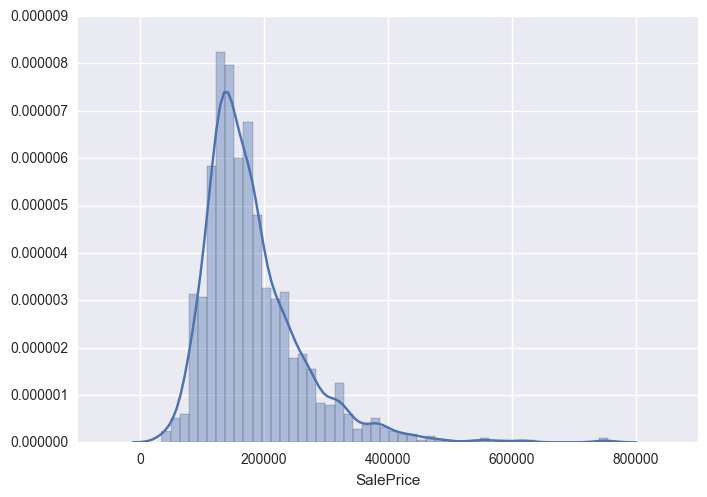

In [155]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

In [156]:
## Log transformation of labels
train_labels = np.log(train_labels)

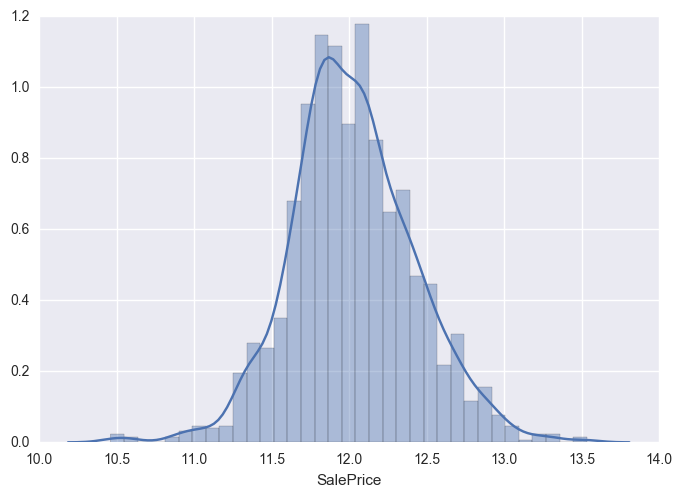

In [158]:
## Now it looks much better
ax = sns.distplot(train_labels)

In [173]:
## Standardizing numeric features
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()
#numeric_features_standardized = ss.fit_transform(numeric_features)

In [174]:
print(numeric_features_standardized.shape)
print(numeric_features.shape)

(2919, 4)
(2919, 4)


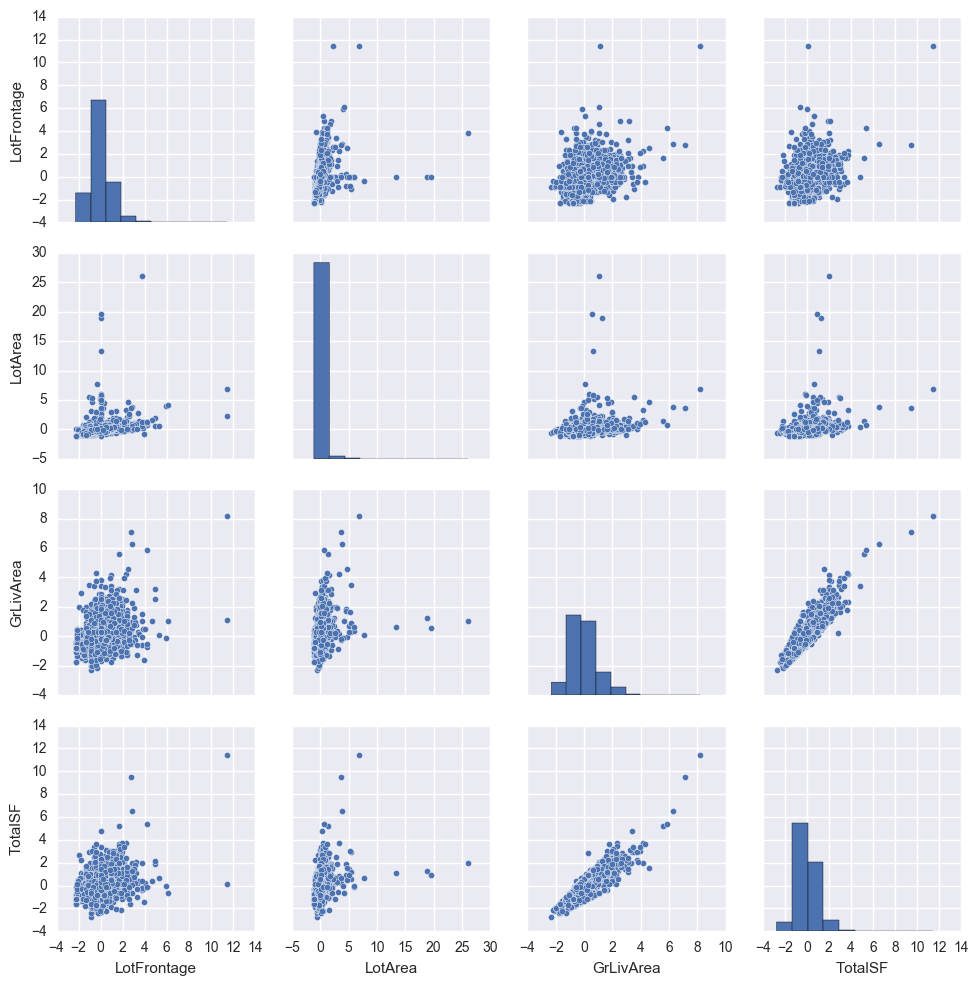

In [175]:
ax = sns.pairplot(numeric_features_standardized)

In [177]:
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)


In [178]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [180]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [182]:
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle


### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)



In [183]:


### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)



In [184]:


ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)




NameError: name 'train_test' is not defined

In [ ]:

GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)

